**License**: BSD <br/>
**Copyright**: Copyright American Gut Project, 2015

<a id="top"></a>

This notebook is designed to demonstrate a set of data analysis techniques for the <a href="http://americangut.org">American Gut Project</a> (AGP) data. It can serve as a framework for other scientists to process the data, examine steps, make suggestions, and ask their own questions. This notebook operates on pre-computed tables available through the <a href="https://github.com/biocore/American-Gut">American Gut GitHub Page</a>, rather than processing the data from raw-sequences. 

This notebook can be run on a personal computer running a UNIX-based operating system (i.e. OSX, Ubantu) which meets the run requirements.  However, running the processing steps on the full notebook - especially steps two and three - take a while (thirty minutes or more) on a personal computer. To reduce run-time, the <code>overwrite</code> parameter should be set to <code><font color="green">False</font></code>, which will only perform these computationally expensive steps if the resulting files are not present. The flag can be re-set (<code>Overwrite = <font color="green">True</font></code>) to re-run the analysis as more data is added to the repository.

To run this notebook, you will need:
<ul><li><a href="http://curl.haxx.se/download.html">The cURL download utility</a>. cURL is installed on Mac OSX 10.6 and higher.
</li><li><a href="https://www.python.org/download/releases/2.7/">Python 2.7</a>
</li><li><a href="http://qiime.org">QIIME 1.9</a>
</li><li><a href="https://github.com/Biocore/American-Gut/">The American Gut GitHub repository.</a>
</li></ul>

This notebook will focus on the generation and analysis of alpha diversity for the American Gut population. Alpha diversity is a measure of intrasample variability or how many and how similar are the species in a particular location.

The notebook will use the following major steps to generate results:
<ol><li><a href="#split">Split the biom table so only fecal samples are examined</a>
</li><li><a href="#rare">Perform ten rarefactions on the dataset at 10,000 sequences/sample</a>
</li><li><a href="#alpha">Calculate alpha diversity for each rarefaction</a>
</li><li><a href="#subset">Generate a subset of healthy adults.</a>
</li><li>Preform analysis. We will look at several metadata categories:
<ul><li><a href="#age">Participant Age</a>
</li><li><a href="#etoh">Alcohol Consumption</a>
</li><li><a href="#season">Collection Season</a>
</li><li><a href="#exercise">Exercise Frequency</a>
</li><li><a href="#sleep">Sleep Duration</a>
</li></ul>
</li></ol>

In [1]:
from os import mkdir
from os.path import abspath, join as pjoin, exists
from shutil import copy2, move
from time import strftime, strptime
from numpy import nan, isnan, arange
from pandas import read_csv, Series, DataFrame
from IPython.display import Image
from americangut.diversity_analysis import (check_dir, 
                                            pad_index,
                                            pretty_pandas_boxplot)

# Initializes the notebook with inline display
%matplotlib inline

ImportError: No module named americangut.diversity_analysis

<a id="filepath"></a>

We can start by setting up some new folders where the data will be downloaded and saved, and filepaths within the folder.

In [2]:
# Gets the base directory for analyses. This is assumed to be the current directory.
base_dir = abspath('.')
# Creates a directory for handling the data
analysis_dir = pjoin(base_dir, 'agp_analysis')
check_dir(analysis_dir)

# Creates a new directory to put the raw OTU table and mapping file we'll download
otu_dir = pjoin(analysis_dir, 'otu_tables') 
check_dir(otu_dir)
raw_dir = pjoin(abspath('..'), 'data/AG/')
check_dir(raw_dir)
# Sets up the location filepaths for the raw data
raw_otu_fp = pjoin(raw_dir, 'AG.biom')
raw_map_fp = pjoin(raw_dir, 'AG_full.txt')

# Creates a directory where tables split by site should be stored
split_dir = pjoin(analysis_dir, 'SplitByBodysite')
check_dir(split_dir)

# Handles renaming the split files
ori_feces_otu_fp = pjoin(split_dir, 'AG__BODY_HABITAT_UBERON:feces__.biom')
ori_feces_map_fp = pjoin(split_dir, 'AG_full__BODY_HABITAT_UBERON:feces__.txt')
raw_feces_otu_fp = pjoin(split_dir, 'AG_fecal.biom')
raw_feces_map_fp = pjoin(split_dir, 'AG_fecal.txt')

# Sets up a directory for rarefaction
rare_dir = pjoin(analysis_dir, 'Rarefaction')
check_dir(rare_dir)

# Sets the filename pattern which will appear for the rarefied table
rare_pattern_fp = pjoin(rare_dir, 'rarefaction_%i_%i.biom')

# Sets up a directory for alpha diverstiy
alpha_dir = pjoin(analysis_dir, 'Alpha')
check_dir(alpha_dir)

# Sets up the alpha diversity filepath
alpha_pattern_fp = pjoin(alpha_dir, 'AG_fecal_even10k_alpha_%i.txt')

# Sets the reference tree filepath. Change as needed to suit your own directories
tree_fp = '/Users/jwdebelius/lib/Greengenes/gg_13_8_otus/trees/97_otus.tree'

<a href="">Return to the top</a>

<a id="parameters"></a>

We can also set a series of parameters for analysis.

<ul><li><code>overwrite</code> will force the computer to re-compute tables, even if a file of the same name already exists.
<br>This can have values of <code><font color="green">True</font></code> and <code><font color="green">False</font></code>.
<br>   

</li><li><code>rarefaction_depth</code> determines how many sequences per sample should be randomly selected.<br>
We chose 10,000 for this analysis because it balances capturing diversity with retaining samples. The American Gut samples have, on average, more sequences per sample than the samples in the Human Microbiome Project, allowing us to use a deeper rarefaction depth in analyzing the data.

</li><li><code>num_rarefactions</code> is the number of times we rarefy the data.<br>
The more rarefactions calculated, the longer it will take the notebook to run. We selected 10 as a compromise between runtime and capturing a fuller picture of the data.
<br>   

</li><li><code>alpha_metrics</code> is a comma-delimited string, listing the desired metrics.<br>
The current notebook is set to calculate two alpha diversity metrics, PD Whole Tree and Observed Species diversity.

</li><li><code>div_metric</code> is the diversity metric to be used during analysis.<br>
While we can calculate a variety of diversity metrics, it is advantageous to focus only on one metric during analysis. Here, we use the mean of the ten PD whole tree diversity calculations. PD whole tree diversity was selected for this analysis because it takes into account not only the number of different organisms present, but also their similarity and dissimilarity.
<br>   

</li><li>The <code>txt_delim</code> character separates cells in our text files. 
Qiime currently works with tab-delimited text format for metadata and alpha diversity files. The delimiter, <code><font color="DC143C">\t</font></code> represents a tab character. A comma separated file (csv) uses a comma (<code><font color="DC143C">,</font></code>) delimiter.

</li><li><code>map_index</code> is the name of the column containing the sample ids. 
This is important for integration between pandas-adjusted metadata and downstream Qiime scripts. The required name in Qiime is <code>#SampleID</code>.

</li><li><code>map_nas</code> lists possible names for empty data fields. 
American Gut participants may skip any survey question they do not wish to answer. As a result, the mapping file may contain missing data fields. Pandas data structures handle these fields by specifying a special value, and ignores them in calculations.

</li></ul>

In [3]:
# Overwrite all current files
overwrite = False

# Sets up rarefaction parameter for 10,000 sequences/sample and 10 rounds of rarefaction.
rarefaction_depth = 10000
num_rarefactions = 10

# Sets the list of alpha diversity metrics to calculate
alpha_metrics = 'PD_whole_tree,observed_species'
# Lists the alpha diversity metric to use for analysis
div_metric = 'PD_whole_tree_mean'

# Sets up parameters for when pandas reads and writes data.
txt_delim = '\t'
map_index = '#SampleID'
map_nas = ['NA', 'no_data', 'unknown']

<a href="#top">Return to the top</a>

Now the parameters and directories are set up, let's get started.

<a href="#top">Return to the top</a>

<a id="split"></a>

###1. Splits the OTU table by Body Site

For more information on splitting out tables using a metadata field, see the <a href="http://qiime.org/scripts/split_otu_table.html">QIIME documentation</a>. <br><em>Note: due to the size of the table, this takes about an hour to run on a laptop with 8gb memory.</em>

In [4]:
# Splits the otu table by body site
if not exists(raw_feces_otu_fp) or overwrite:
    !split_otu_table.py -i $raw_otu_fp -m $raw_map_fp -f BODY_HABITAT -o $split_dir
    # Renames the fecal files to something tidier
    copy2(ori_feces_otu_fp, raw_feces_otu_fp)
    copy2(ori_feces_map_fp, raw_feces_map_fp)

<a href="#top">Return to the top</a>

<a id="rare"></a>

###3. Rarefy the table

<p>Next, we rarefy the data to 10,000 sequences per sample. This depth was chosen since it balances a better picture of diversity with retaining samples. Rarefaction begins by removing samples from the table which do not have the minimum number of counts. Sequences are then drawn randomly out of a weighted pool until we reach the appropriate number. </p>

Rarefaction is necessary to make intra sample diversity comparisons possible. Below is a panel from Figure 1 of <a href="http://jnci.oxfordjournals.org/content/early/2013/11/27/jnci.djt300.full">Human Gut Microbiome and Risk of Colorectal Cancer</a> (Ahn et al, 2013). The figure compares <a href="http://en.wikipedia.org/wiki/Diversity_index#Shannon_index">Shannon Diversity</a> between individuals with colorectal cancer (n=47, red circles) and healthy controls (n=94, empty triangles) over several rarefaction depths, or sequence counts per sample. The figure also illustrates the importance of even sampling depth. If a control sample with 500 sequences per sample were compared with a cancer sample at a depth of 2500 sequences per sample, the cancer sample would appear more diverse. Comparisons at the same depth reveal the true pattern in the data: cancer samples are less diverse than controls.


In [5]:
Image(url='https://github.com/biocore/American-Gut/blob/master/ipynb/images/ahn2013jncicolorectalf1.jpg?raw=true', 
      height=300, width=300*4/3)

<p>To control for bias which might occur with a single, random subsampling of the data, we use multiple rounds of rarefaction to more accurately estimate the alpha diversity.</p>
<p><em>Note: due to the size of the table, this takes about an hour to run on a laptop with 8gb of memory.</em></p>

In [6]:
# Preforms multiple rarefactions at an even depth
if not exists(rare_pattern_fp % (rarefaction_depth, 9)) or overwrite:
    !multiple_rarefactions_even_depth.py -i $raw_feces_otu_fp -o $rare_dir -d $rarefaction_depth -n $num_rarefactions  --lineages_included

<a href="#top">Return to the top</a>

<a id="alpha"></a>

###4. Calculate alpha diversity for the samples
Alpha diversity is a measure of intra sample diversity, or how much variability we find in each sample. There are a variety of ways to calculate alpha diversity. This notebook will calculate two metrics: Observed Species Diversity and PD Whole Tree Diversity.

<a href="http://scikit-bio.org/generated/skbio.math.diversity.alpha.observed_otus.html#skbio.math.diversity.alpha.observed_otus">Observed Species Diversity</a>  counts the number of bacterial species in a sample. Imagine looking at three households. In household one, there are three humans. In household two, there is a human, a dog, and a rat. In household three, there is a human, a dog, and a bearded dragon. Using observed species diversity, we would say that household one is less diverse than Household two and three, which by Observed species diversity are equally diverse. (H<sub>1</sub> < H<sub>2</sub> = H<sub>3</sub>).

However, when examining diversity, it can be useful to look beyond just the number of bacterial species present, and instead look at some of the bacterial traits. <a href="http://www.sciencemag.org/content/308/5728/1635.full">PD Whole Tree Diversity</a> is a diversity metric which takes into account the evolutionary similarity between different bacterial species. For example, going back to the households we talked about earlier, household one with its three humans would again be the least diverse, because we are only looking at one species. Household two and household three both have the same number of species, but household three would be considered more diverse since it contains a reptile (the bearded dragon) while household two only contains mammals, and mammals are more similar to each other than a reptile. (H<sub>1</sub> < H<sub>2</sub> < H<sub>3</sub>).

In [7]:
# Sets up a holding object for the alpha diversity
alpha_rounds = {'%s' % m:{} for m in alpha_metrics.split(',')}

# Calculates the alpha diversity for each round
for i in arange(0, 10):
    rare_fp = rare_pattern_fp % (rarefaction_depth, i)
    alpha_fp = alpha_pattern_fp % i
    # Calculates the alpha diversity
    if not exists(alpha_fp):
        !alpha_diversity.py -i $rare_fp -o $alpha_fp -m $alpha_metrics -t $tree_fp

    # Reads in the alpha diversity
    alpha = pad_index(read_csv(alpha_fp, sep='\t'), 'Unnamed: 0')

    # Pulls out the data
    for col in alpha_rounds:
        alpha_rounds['%s' %col]['%i' % i] = alpha[col]
        alpha_rounds['%s' %col]['%i' % i].name = '%i' % i
        
# Calculates the mean, median and standard deviaton between rounds
metrics = {}
for metric in alpha_rounds:
    metrics['%s_mean' % metric] = DataFrame(alpha_rounds[metric]).mean(1)
    metrics['%s_stdv' % metric] = DataFrame(alpha_rounds[metric]).std(1)
    metrics['%s_med' % metric] = DataFrame(alpha_rounds[metric]).median(1)
    
# Adds the alpha diversity to the mapping file
aw_map = pad_index(read_csv(raw_map_fp, 
                            sep=txt_delim, 
                            na_values=map_nas),
                   index_col=map_index)
alpha_df = DataFrame(metrics)
if '%s_mean' % alpha_rounds.keys()[0] not in aw_map.columns:
    aw_map = aw_map.join(alpha_df)

/Users/jerry/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (11,25,125) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


After reading in the mapping file, we can remove any sample which did not contain the 10,000 sequences/sample we requested using rarefaction. Since the missing alpha diversity is stored as a Not a Number (<code>nan</code>) value, we will ask the computer to only keep metadata rows where the alpha diversity is not <code>nan</code>.

In [8]:
aw_map = aw_map.groupby(isnan(aw_map['%s_mean' % alpha_rounds.keys()[0]])).get_group(False)

<a href="#top">Return to the top</a>

<a id="subset"></a>

###5. Filters out samples with known effects on diversity.

<p>Certain health aspects of participants may have known influences on alpha diversity which overwhelms other potential influences. As a result, we chose to filter out individuals who may belong to a group which confounds the data.</p>

<p><a href="http://www.pnas.org/content/108/Supplement_1/4554.long">Recent antibiotic use</a> has been shown to affect alpha diversity; only participants who reported not using antibiotics in the last year were considered in this analysis.</p>

<p><a href="http://www.ncbi.nlm.nih.gov/pubmed/23013615">Inflammatory Bowel Disease</a>
and 
<a href="http://www.ncbi.nlm.nih.gov/pubmed/20140211">Type II diabetes</a>
are associated with decreased alpha diversity compared to age-matched controls. 
Studies examining alpha diversity in Type I diabetes have been somewhat inconclusive. 
<a href="http://www.ncbi.nlm.nih.gov/pubmed/20613793">Giongo et al, 2011</a>
showed decreased diversity in diabetics (<em>n</em>=4) compared to controls (<em>n</em>=4) over time, while 
<a href="http://www.ncbi.nlm.nih.gov/pubmed/24448554">Mejía-Leon et al, 2014</a>
found no significant difference in alpha diversity between controls (<em>n</em>=8), newly diagnosed cases (<em>n</em>=8) and children who had been diabetic for more than two years (<em>n</em>=13) at a single time point. We chose to be conservative and exclude type I diabetics from this dataset. 

A relationship between 
<a href="http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2677729/">obesity</a>
and lower alpha diversity has also been previously observed. In addition, we found that individuals who were considered underweight also had lower diversity than people in the "normal" or "overweight" BMI categories. As a result, we selected only to include subjects who had a BMI between 18.5 and 30.

We removed anyone under the age of 20 for three reasons: 
<a href="http://www.ncbi.nlm.nih.gov/pubmed/22699611">young children</a>
have low diversity compared to adults. 
<a href="http://win.niddk.nih.gov/statistics/">BMI qualifications in children under 18</a>
into categories such as "underweight", "normal", and "overweight" depend on the child's age and gender. Finally, we considered alcohol consumption as a variable which might affect alpha diversity. Since the overwhelming majority of American Gut participants are American, we chose to set the lower limit of the age range near the legal drinking age to remove potential age-related biases.

To filter the data, we define a series of filter functions. A sample must pass all five filter functions to be used in analysis. For large sets of data, it is more convenient to define a single filtered set using the Pandas function, <a href="http://pandas.pydata.org/pandas-docs/dev/generated/pandas.DataFrame.apply.html"><code>apply</code></a> and then splitting the table based on the aggregated results, rather than splitting the table individually using each filter function.

In [9]:
# Defines the filtering functions for alpha diversity
subset_f = {'AGE': lambda x: 19 < x and not isnan(x),          
            'DIABETES': lambda x: x == 'I do not have diabetes',
            'IBD': lambda x: x == 'I do not have IBD',
            'ANTIBIOTIC_SELECT': lambda x: x == 'Not in the last year',
            'BMI': lambda x: 18.5 <= x < 30 and not isnan(x)}

# Determines which samples meet the requirements of the categories
new_bin = {}
for cat, f in subset_f.iteritems():
    new_bin[cat] = aw_map[cat].apply(f)

# Builds up the new binary dataframe
bin_frame = DataFrame(new_bin)

# Adds a column to the current dataframe to look at the subset
bin_series = DataFrame(new_bin).all(1)

# Filters the original mapping file so only samples which satisfy the criteria are included in the new metadata file.
sw_map = aw_map.groupby(bin_series).get_group(True)

<a href="#top">Return to the top</a>

###6. Analysis

<a id="age"></a>

####Age in years
The microbiome changes throughout an individual's life time. Drastic shifts are seen within the 
<a href=" http://www.ncbi.nlm.nih.gov/pubmed/22699611">first three years of life</a>,
when the microbiome is generally believed to be settling into an adult configuration. 
<a href="http://www.ncbi.nlm.nih.gov/pubmed/21624126">Looking at an indiviudal over time</a>
shows changes in an indiivudal, although the changes within an individual are smaller than the difference between two individuals or two body sites ont he same individual. 

Here, we can use the clean subset of adults to look for changes in diversity as a population ages. Participants provided their age in years, or were free to skip the question. However, sometimes it's easier to see patterns if we can create groups in the data. We can convert continous data to categorical data in two steps:
<ol><li>Define a mapping dictionary with partitions. Here, we use <a href="https://docs.python.org/2/tutorial/controlflow.html#if-statements">if statements</a> in our function.
</li><li>Apply the function to the continous data column, and save it to a new column in the data frame.
</li></ol>


We're going to map continous age into decade. So, we'll use if/else logic to convert to decades.

In [10]:
def convert_age(x):
    """Converts continous age to decade categories"""
    if isnan(x):
        return x
    elif x < 30:
        return "20s" 
    elif x < 40:
        return "30s"
    elif x < 50:
        return "40s"
    elif x < 60:
        return "50s"
    else:
        return "60+"
age = sw_map['AGE'].apply(convert_age)
    
# Applies the function to create a new column, AGE_CAT
sw_map['AGE_CAT'] = age

Since age by decade has an order, and that order is important in our ability to understand and interpret what we're seeing, we can set the order automatically.

In [11]:
age_order = ['20s', '30s', '40s', '50s', '60+']

We approached the question of age by looking at the PD whole tree diversity within the subjects. We started by using 
<a href="http://en.wikipedia.org/wiki/Box_plot">boxplots</a> and a 
<a href="http://en.wikipedia.org/wiki/Kruskal–Wallis_one-way_analysis_of_variance">krushkal-wallis</a>
test to compare alpha diversity between groups. In the boxplots shown below, the notch indicates a parametric 95% confidence interval.

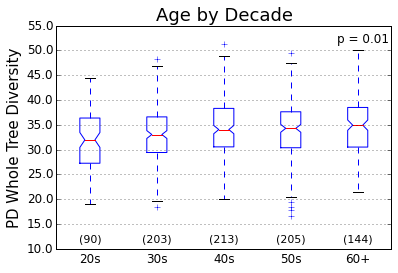

In [12]:
a_fig = pretty_pandas_boxplot(sw_map,
                              'AGE_CAT',
                              order=age_order,
                              cat=div_metric,
                              ylabel='PD Whole Tree Diversity',
                              title='Age by Decade',
                              ylim=[10, 55])

The box plots suggest that alpha diversity increases as age increases. 

<a href="#top">Return to the top</a>

<a id="etoh"></a>

####Alcohol Frequency
<p>With the clean subset of data, we can start investigating the data. 
One question of interest to our group was the effect of alcohol consumption on diversity of the gut microbiome.</p>

In [13]:
# Identifies the metadata category being analyzed
category = 'ALCOHOL_FREQUENCY'

We asked participants about their frequency of alcohol consumption, providing the options "<code>Never</code>", "<code>Rarely, a few times/month</code>", "<code>Occasionally, 1-2 times/week</code>", "<code>Regularly, 3-5 times/week</code>" and "<code>Daily</code>". Partipants were also free to skip this question.

Because of the lenght of many group names, we chose to shorten them.

In [14]:
# Applies the function.
sw_map.loc[sw_map.ALCOHOL_FREQUENCY=='Rarely (few times/month)', 'ALCOHOL_FREQUENCY'] = 'Rarely'
sw_map.loc[sw_map.ALCOHOL_FREQUENCY=='Occasionally (1-2 times/week)', 'ALCOHOL_FREQUENCY'] = 'Occasionally'
sw_map.loc[sw_map.ALCOHOL_FREQUENCY=='Regularly (3-5 times/week)', 'ALCOHOL_FREQUENCY'] = 'Regularly'

Because of the inherent ordinal nature of the data, we choose to order groups in ascending order of their consumption frequency. If we do not define this order, the  plotting function will sort the data alphabetically, which will make less sense.

In [15]:
order = ['Never', 'Rarely', 'Occasionally', 'Regularly', 'Daily']

We then generated a boxplot and post-hoc analysis for the alcohol frequency

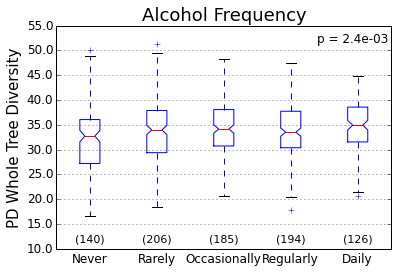

In [16]:
fig= pretty_pandas_boxplot(sw_map,
                           category,
                           order=order,
                           cat=div_metric,
                           ylabel='PD Whole Tree Diversity',
                           title='Alcohol Frequency',
                           ylim=[10, 55])

The post-hoc test shows that adults who don't drink have signifignatly lower PD whole tree alpha diversity than any group of adults who consume alcohol, and that the frequency of consumption does not siginfigantly increase the diversity between the groups of drinkers.

<a href="#top">Return to the top</a>

<a id="season"></a>

####Collection Month

<p>Another area of interest for our group was to look at the effect of season on the human gut microbiome. Previous work has shown seasonal effects on alpha diversity on the microbiome of a variety of environments, including the 
<a href="http://www.ncbi.nlm.nih.gov/pubmed/22071345">English Channel</a>
and 
<a href= "http://www.ncbi.nlm.nih.gov/pubmed/23152108">squirrels gut microbiomes</a>
. A recently published paper examined seasonal variation in 
<a href="http://www.ncbi.nlm.nih.gov/pubmed/24618913">Hutterite communities of South Dakota</a>
.</p>

<p>Before submitting samples for analysis, participants were asked for the collection date and time. We chose to look at alpha diversity during the year, combining samples collected in 2013 and 2014 into months. The information was stored as a standard calendar date, and so, to get the month, we once again have to parse the data. In this case, we will create a new metadata category for the parsed field.</p>

In [17]:
# Sets up the category parameters
category = 'COLLECTION_MONTH'
base_cat = 'COLLECTION_DATE'

# Sets a function to convert the collection date, if necessary
def get_month(date_str):
    """converts a date to a month string"""
    if len(date_str) > 8:
        return strftime('%B', strptime(date_str, '%m/%d/%Y'))
    else:
        return strftime('%B', strptime(date_str, '%m/%d/%y'))
# Converts the collection date
if category not in sw_map.columns:
    sw_map[category]= sw_map[base_cat].apply(get_month)

We set the calender order for the months, since, once again, the order of the data matters, and we generate a boxplot. This boxplot uses rotated axis labels to allow everything to fit.

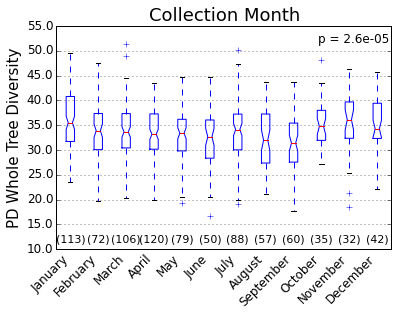

In [18]:
order = ['January', 'February', 'March', 'April', 'May', 'June', 
         'July', 'August', 'September', 'October', 'November', 
         'December']

fig = pretty_pandas_boxplot(sw_map,
                            category,
                            order=order,
                            cat='PD_whole_tree_mean',
                            ylabel='PD Whole Tree Diversity',
                            title='Collection Month',
                            xfont_angle=45,
                            xfont_align='right',
                            ylim=[10, 55])

The boxplot of collection month suggests that alpha diversity is higher in the late fall and early winter (November, December, January) than other months.

<a href="#top">Return to the top</a>

<a id="exercise"></a>

####Exercise
We also had questions about the effect of exercise on the microbiome. Particiapants were asked if they exercised <code>Never</code>, <code>Rarely, (few times/month)</code>, <code>Occasionally (1-2 times/week)</code>, <code>Regularly, (3-5 times/week)</code> and <code>Daily</code>. They were also asked where they exercised: <code>Indoors</code>, <code>Outdoors</code>, <code>Both</code>, <code>Depends on the season</code> and <code>None of the above</code>. Partipants were also free to omit this question.

We're going to start by looking at the effect of exercise frequency. We'll start by checking the number of samples in each group, since we need a certain number of samples to be able to make a fair comparison between categories. 

In [19]:
order_1 = ['Never', 'Rarely (few times/month)', 'Occasionally (1-2 times/week)',
           'Regularly (3-5 times/week)', 'Daily']
sw_map.groupby('EXERCISE_FREQUENCY').count().PD_whole_tree_mean.loc[order_1]

EXERCISE_FREQUENCY
Never                             14
Rarely (few times/month)          72
Occasionally (1-2 times/week)    172
Regularly (3-5 times/week)       383
Daily                            214
Name: PD_whole_tree_mean, dtype: int64

Of 904 samples in the healthy subset for rounds 1-10, only 14 individuals report <code>Never</code> exercising, so we'll combine them with the people who report rarely exercising. As a result, we combine samples from people who report never exercising and people who report rarely exercising into a single category, <code>Rarely</code>. We also remove the long descriptors from the map name.

In [20]:
# Applies the function.
sw_map.loc[sw_map.EXERCISE_FREQUENCY=='Never','EXERCISE_FREQUENCY'] = 'Rarely'
sw_map.loc[sw_map.EXERCISE_FREQUENCY=='Rarely (few times/month)','EXERCISE_FREQUENCY'] = 'Rarely'
sw_map.loc[sw_map.EXERCISE_FREQUENCY=='Occasionally (1-2 times/week)','EXERCISE_FREQUENCY'] = 'Occasionally'
sw_map.loc[sw_map.EXERCISE_FREQUENCY=='Regularly (3-5 times/week)','EXERCISE_FREQUENCY'] = 'Regularly'

Let's use a boxplot to visualize the exercise frequency. Again, we'll set an order for the data.

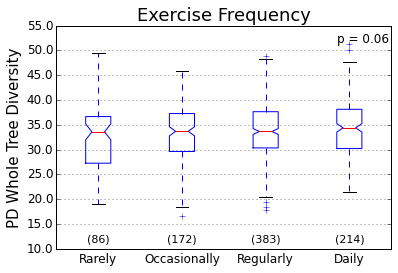

In [21]:
# Sets the frequency order
order = ['Rarely', 'Occasionally', 'Regularly', 'Daily']

# Generates a boxplot
fig = pretty_pandas_boxplot(sw_map,
                            'EXERCISE_FREQUENCY',
                            order=order,
                            cat=div_metric,
                            ylabel='PD Whole Tree Diversity',
                            title='Exercise Frequency',
                            ylim=[10, 55])

Exercise frequency has some effect; we can also look at the influence of exercise location on alpha diversity. In rounds 1-10, there are only 10 people who report the <code>None of the above</code> category. 

In [22]:
sw_map.groupby('EXERCISE_LOCATION').count().PD_whole_tree_mean

EXERCISE_LOCATION
Both                     267
Depends on the season    100
Indoors                  167
None of the above         10
Outdoors                 276
Name: PD_whole_tree_mean, dtype: int64

For the sake of simplicity, let's treat this as an unknown answer, since the category is so small compared to the rest of the data that our krushkall wallis will be more prone to error. Let's also shorten "Depends on the season" to "Depends" to make the x-axis labels cleaner.

In [23]:
sw_map.loc[sw_map.EXERCISE_LOCATION=='Depends on the season','EXERCISE_LOCATION'] = 'Depends'
sw_map.loc[sw_map.EXERCISE_LOCATION=='None of the above','EXERCISE_LOCATION'] = nan

We can now create a boxplot of the exericse location. 

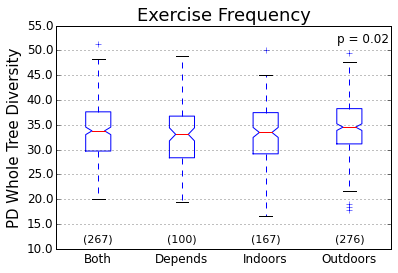

In [24]:
# Generates a boxplot
fig = pretty_pandas_boxplot(sw_map,
                            'EXERCISE_LOCATION',
                            order=None,
                            cat=div_metric,
                            ylabel='PD Whole Tree Diversity',
                            title='Exercise Frequency',
                            ylim=[10, 55])

<a href="#top">Return to the top</a>

<a id="sleep"></a>

####Sleep Duration
We also decided to look at the effect of sleep duration on microbial diversity. We asked participants how much sleep they got, on average. Options were <code>Less than 5 hours</code>, <code>5-6 hours</code>, <code>6-7 hours</code>, <code>7-8 hours</code> or <code>8 or more hours</code> or to leave the question blank. It seems unlikely that many people would sleep less than 5 hours, so we start by checking the number of indiviudals who gave each response.

In [25]:
sleep_order = ['Less than 6 hours', '6-7 hours', '7-8 hours', '8 or more hours']

Now, we can generate a boxplot showing the changes in alpha diversity associated with sleep.

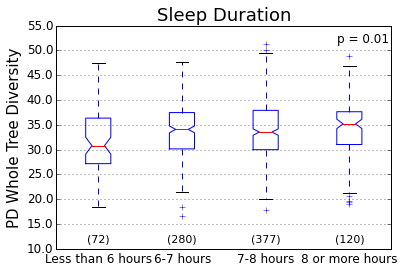

In [26]:
fig = pretty_pandas_boxplot(sw_map,
                            'SLEEP_DURATION',
                            order=sleep_order,
                            cat=div_metric,
                            ylabel='PD Whole Tree Diversity',
                            title='Sleep Duration',
                            ylim=[10, 55])

People who sleep longer appear to have higher alpha diversity.

<a href="#top">Return to the top</a>